<div>
    <div style="float:left;width:50%;text-align:center">
        <h1>pyGIMLi Tutorial @ Transform 2021</h1>
        <div>
<table style="border-collapse:collapse;border-color:#ccc;border-spacing:0" class="tg"><thead><tr><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal"></th><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Info</th></tr></thead><tbody><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">When</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Monday, April 19 • 8:00 - 9:00 UTC (starts at 10.00 a.m. CET)</td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Slack (Q&amp;A)</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://softwareunderground.org/">Software Underground</a> channel <a href="https://swung.slack.com/archives/C01T5V5S9EV">#t21-mon-pygimli</a></td></tr><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Live stream</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://youtu.be/w3pu0H3dXe8">https://youtu.be/w3pu0H3dXe8</a></td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">pyGIMLi documentation</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.pygimli.org/documentation.html">https://www.pygimli.org/documentation.html</a></td></tr></tbody></table>
        </div>
    </div>
    <div style="float:right;width:30%">
        <img src="https://www.pygimli.org/_images/pg_logo.png" alt="pyGIMLi logo">
    </div>
</div>

---
# Simulating crosshole traveltime measurements

## Objectives

In this tutorial, we want to:
1. Read the geometry created in the [first notebook](./1_Creating_a_subsurface_model.ipynb)
2. Define two wells with seismic sources and receivers
3. Populate the subsurface model with parameters (seismic slownesses)
4. Simulate traveltime measurements with noise

---

In [19]:
# Just some plotting settings
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg' # Setting figure format for this notebook

## Read in the previously defined geometry

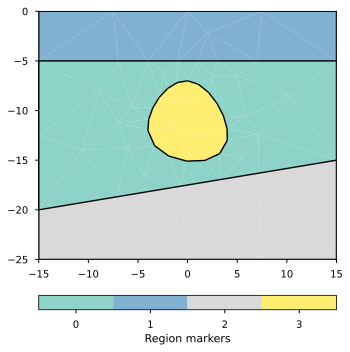

In [83]:
import pygimli as pg
import pygimli.meshtools as mt

geometry = mt.readPLC("geometry.poly")
geometry.scale([0.5, 1, 1])

ax, _ = pg.show(geometry)

## Define source and receiver positions

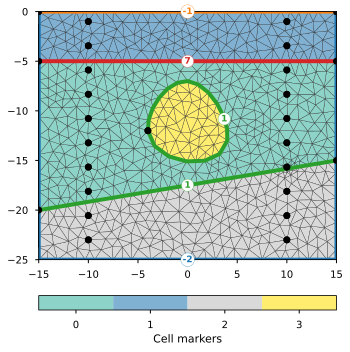

In [104]:
import numpy as np

n = 10 # number of sources and receivers per borehole
borehole = np.ones((n, 2)) * 10 # right borehole at x = 10 m
borehole[:,1] = np.linspace(-1, -23, n) # down to 23 m depth

sensors = np.vstack([borehole] * 2)
sensors[n:,0] *= -1 # left borehole at x = -10 m

ax.plot(sensors[:,0], sensors[:,1], "ko")
ax.figure

(<AxesSubplot:>, None)

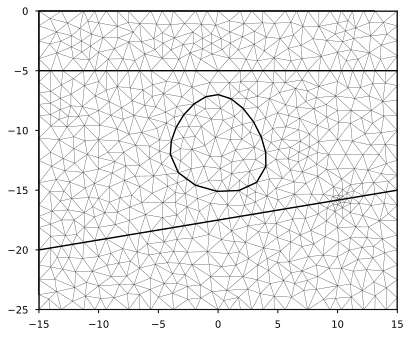

In [157]:
for pos in sensors:
    geometry.createNode(pos)
    
mesh = mt.createMesh(geometry, quality=33, area=1)
pg.show(mesh)

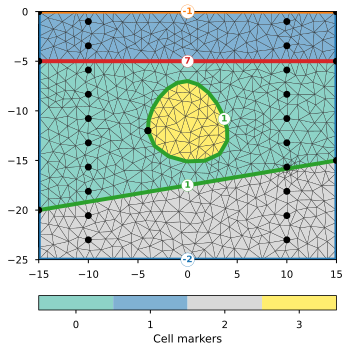

In [158]:
ax, _ = pg.show(mesh, markers=True, showMesh=True)
ax.plot(sensors[:,0], sensors[:,1], "ko")

# WILL BE MOVED TO PG-FUNCTION LATER

In [159]:
from itertools import product
numbers = np.arange(len(sensors))
rays = list(product(numbers, numbers + len(numbers)))

# Empty container
scheme = pg.DataContainer()

# Add sensors
for sen in sensors:
    scheme.createSensor(sen)

# Add measurements
rays = np.array(rays)
scheme.resize(len(rays))
scheme["s"] = rays[:, 0]
scheme["g"] = rays[:, 1]
scheme["valid"] = np.ones(len(rays))
scheme.registerSensorIndex("s")
scheme.registerSensorIndex("g")


In [160]:
mesh.setCellMarkers(mesh.cellMarkers() + 1)

In [161]:
    
vel_map = [
    [1, 500],
    [2, 500],
    [3, 500],
    [4, 500]
]

slowness = 1 / pg.solver.parseMapToCellArray(vel_map, mesh, default=1000)

In [162]:
from pygimli.physics.traveltime import TravelTimeManager
tt = TravelTimeManager()
data = tt.simulate(mesh=mesh, scheme=scheme, slowness=slowness,
                   secNodes=4, noiseLevel=0.001, noiseAbs=1e-5, seed=1337)

17/04/21 - 15:01:17 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.


In [163]:
data.save("test.dat")

1

In [164]:

    
invmodel = tt.invert(data, mesh=mesh, secNodes=3, lam=1000, zWeight=1.0,
                     useGradient=False, verbose=True)

17/04/21 - 15:01:22 - pyGIMLi - INFO - Found 4 regions.
17/04/21 - 15:01:22 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
17/04/21 - 15:01:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/04/21 - 15:01:22 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
17/04/21 - 15:01:22 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
17/04/21 - 15:01:22 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
17/04/21 - 15:01:22 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7fc8380ac310>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7fc8380ac6d0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7fc8380ac3b0>
min/max (data): 0.010/0.068
min/max (error): 0.11%/0.20%


IndexError:  20 [0..20)
n/git/gimli/trunk/core/src/vector.h:577		const ValueType& GIMLI::Vector<ValueType>::getVal(GIMLI::Index) const [with ValueType = GIMLI::Pos; GIMLI::Index = long unsigned int] 